In [154]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

import math
import time

import skrf
from skrf import Network

import utils
import os

from skimage.metrics import peak_signal_noise_ratio as psnr

In [155]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# Grab some data

In [156]:
ROOT_PATH = "/scratch/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 9

In [157]:
test_net = utils.get_network_from_file(ROOT_PATH, CHIP_NUM)['network']

In [158]:
print("S-parameters shape: ", test_net.s.shape)
print("S-parameters type: ", test_net.s.dtype)

S-parameters shape:  (1000, 4, 4)
S-parameters type:  complex128


In [159]:
N_PORTS = test_net.nports
N_FREQS = test_net.frequency.npoints

print("N_FREQS: ", N_FREQS)
print("N_PORTS: ", N_PORTS)

N_FREQS:  1000
N_PORTS:  4


## We gonna keep the original dimension even if it's reciprocal

# Grab the HLAS results

In [160]:
case_str = "case" + (str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM))
case_fname = os.path.join(ROOT_PATH, case_str)

print(case_fname)

/scratch/04703/sravula/UTAFSDataNew/new_data/case09


In [161]:
children = os.listdir(case_fname)

time_fpth = [f for f in children if "TIME" in f][0]
time_fpth = os.path.join(case_fname, time_fpth)

HLAS_fpth = [f for f in children if "HLAS.s" in f][0]
HLAS_fpth = os.path.join(case_fname, HLAS_fpth)

HLAS_meas_fpth = [f for f in children if "SIMULATIONS" in f][0]
HLAS_meas_fpth = os.path.join(case_fname, HLAS_meas_fpth)

print(time_fpth)
print(HLAS_fpth)
print(HLAS_meas_fpth)

/scratch/04703/sravula/UTAFSDataNew/new_data/case09/SIEMENS_AFS_TIME_IN_SECONDS.txt
/scratch/04703/sravula/UTAFSDataNew/new_data/case09/case09.HLAS.s4p
/scratch/04703/sravula/UTAFSDataNew/new_data/case09/SIEMENS_AFS_SAMPLE_POINT_SIMULATIONS.s4p


In [162]:
HLAS_net = Network(HLAS_fpth)
HLAS_meas_net = Network(HLAS_meas_fpth)

with open(time_fpth) as file:
    lines = [line.rstrip() for line in file]
HLAS_time = lines[0]

In [163]:
print("HLAS time: ", HLAS_time)

HLAS time:  31.30984377861023


In [164]:
print("HLAS shape: ", HLAS_net.s.shape)
print("HLAS meas shape: ", HLAS_meas_net.s.shape)

HLAS shape:  (1000, 4, 4)
HLAS meas shape:  (132, 4, 4)


In [165]:
M_HLAS = HLAS_meas_net.s.shape[0]
print(M_HLAS)

132


In [166]:
test_net_twochan = np.stack((test_net.s.real, test_net.s.imag), axis=-1)
HLAS_net_twochan = np.stack((HLAS_net.s.real, HLAS_net.s.imag), axis=-1)

print(test_net_twochan.shape)
print(test_net_twochan.dtype)

print(HLAS_net_twochan.shape)
print(HLAS_net_twochan.dtype)

(1000, 4, 4, 2)
float64
(1000, 4, 4, 2)
float64


In [167]:
HLAS_psnr = psnr(test_net_twochan, HLAS_net_twochan)
print("HLAS PSNR: ", HLAS_psnr)

HLAS PSNR:  37.34894236920967


# Grab a toch tensor from this guy

In [168]:
x_test = utils.network_to_sparams(test_net)
print(x_test.shape)
print(x_test.dtype)

torch.Size([1, 32, 1000])
torch.float32


In [169]:
x_HLAS = utils.network_to_sparams(HLAS_net)
print(x_HLAS.shape)
print(x_HLAS.dtype)

torch.Size([1, 32, 1000])
torch.float32


In [170]:
y_HLAS = utils.network_to_sparams(HLAS_meas_net)
print(y_HLAS.shape)
print(y_HLAS.dtype)

torch.Size([1, 32, 132])
torch.float32


# Grab some measurements

In [171]:
MEASUREMENT_SPACING = "equal"
M = 0.15

KEPT_INDS, MISSING_INDS = utils.get_inds(MEASUREMENT_SPACING, N_FREQS, M)

M = len(KEPT_INDS)

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)

Number of Ground Truth Frequency Points:  1000
Number of Measurements:  150
Undersampling Ratio:  0.15


In [172]:
y = torch.clone(x_test)[:, :, KEPT_INDS]

print("y shape: ", y.shape)

y shape:  torch.Size([1, 32, 150])


In [173]:
z = torch.clone(x_test)
z[:, :, MISSING_INDS] = 0

print("z shape: ", z.shape)

z shape:  torch.Size([1, 32, 1000])


# Plot the Data and measurements 

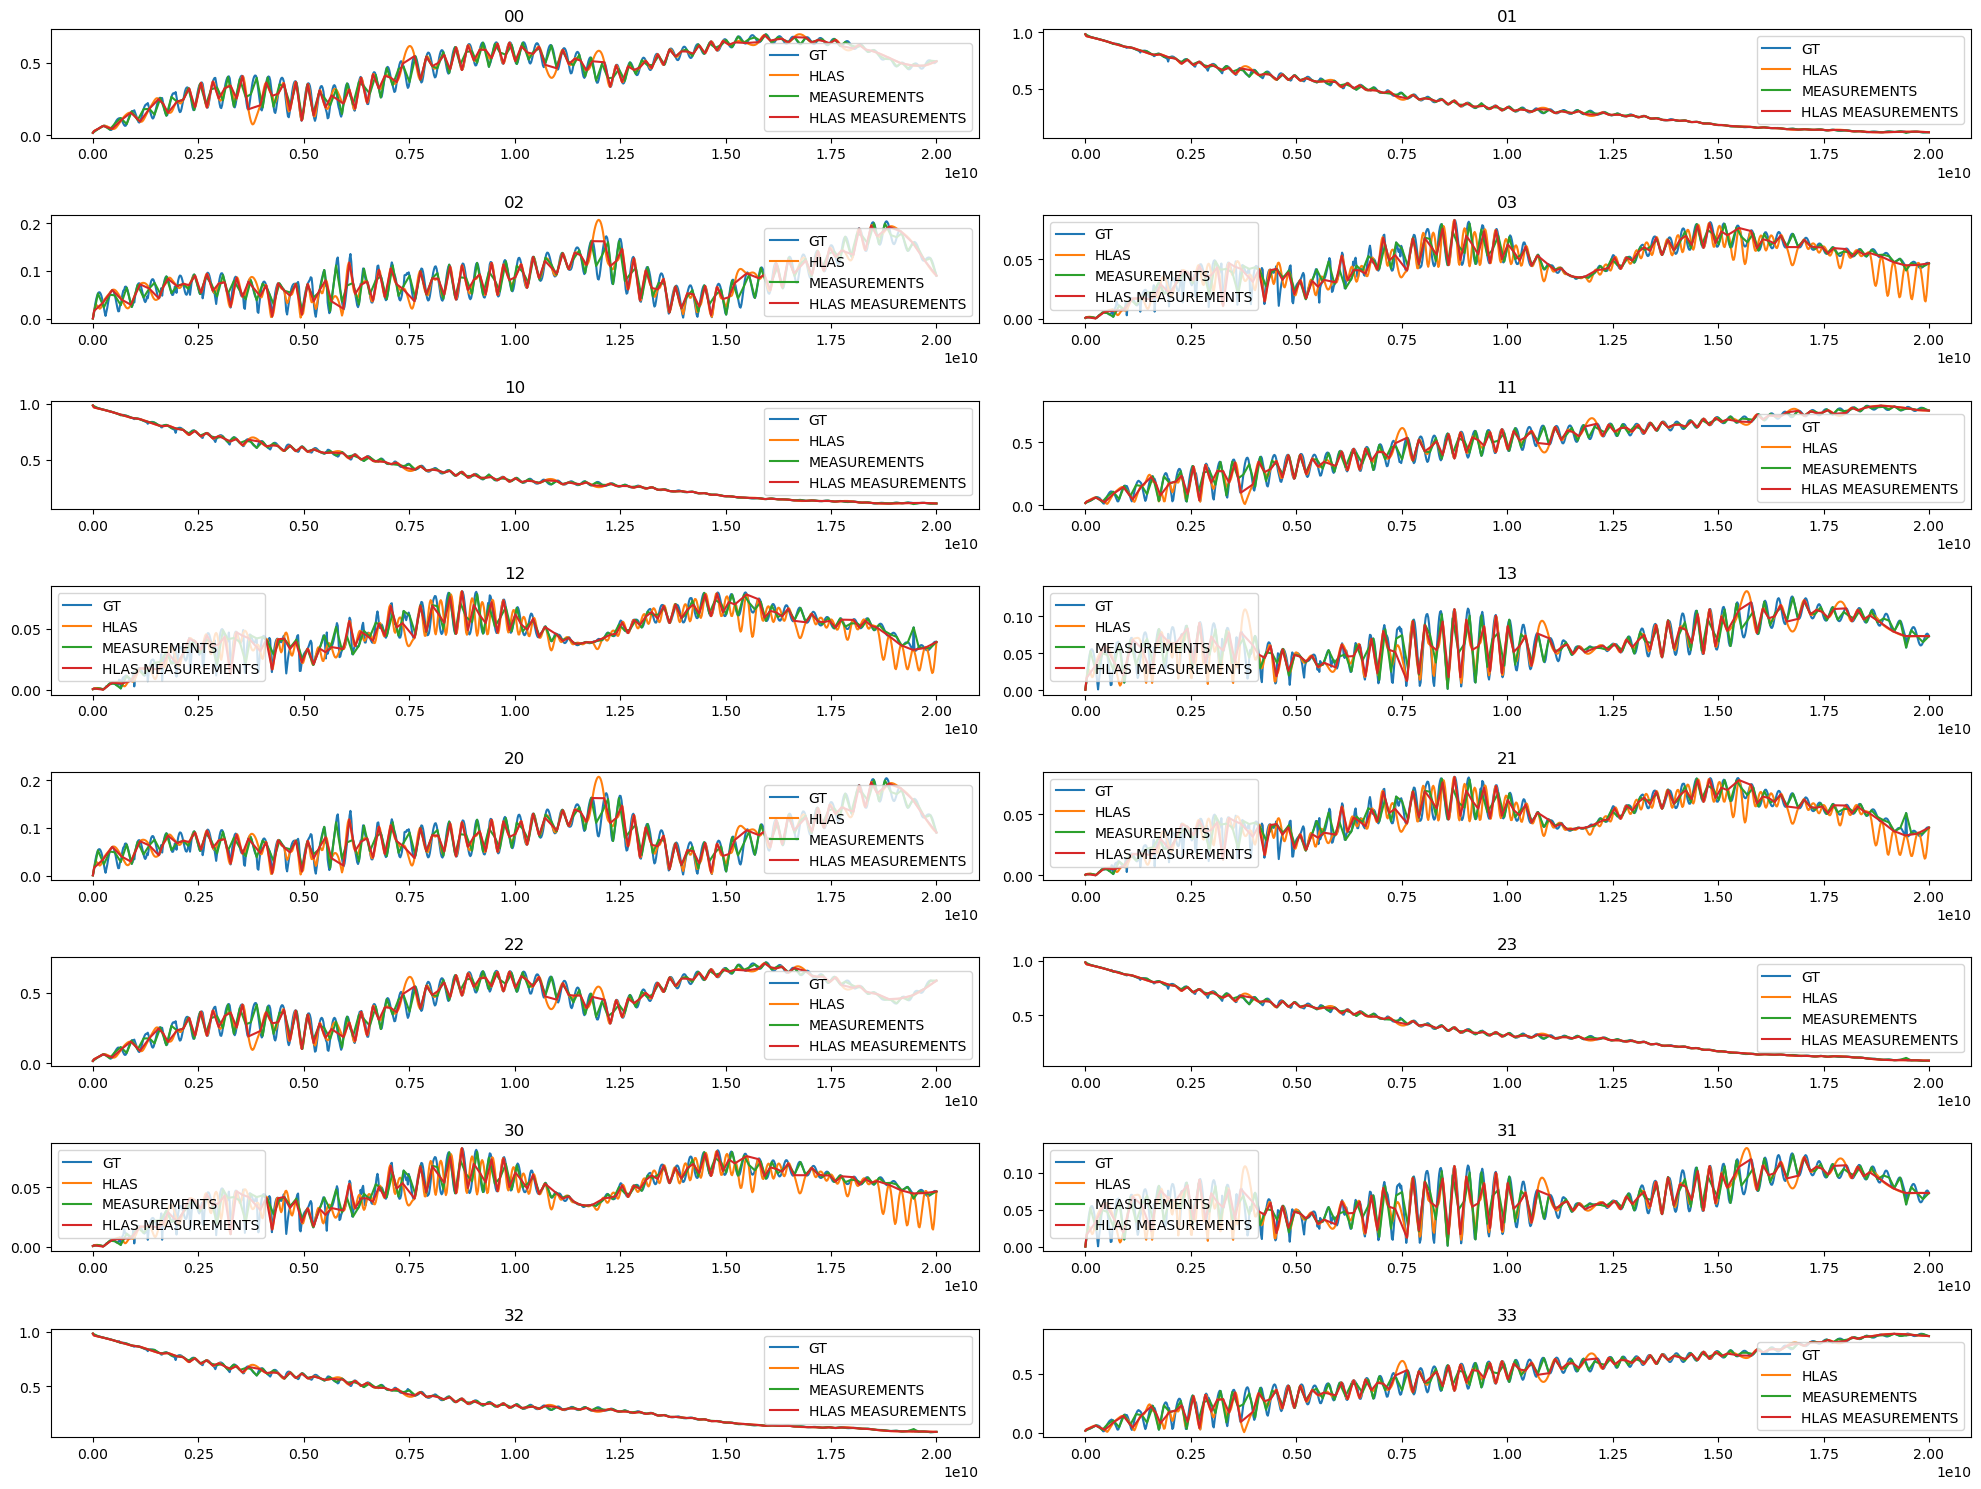

In [174]:
utils.plot_mags([x_test, x_HLAS, y, y_HLAS], 
          freqs=[test_net.f, test_net.f, test_net.f[KEPT_INDS], HLAS_meas_net.f], 
          chip_labels=["GT", "HLAS", "MEASUREMENTS", "HLAS MEASUREMENTS"], 
          not_reciprocal=True,
          plot_subset_list=[0,1,2,3],
          ylims=False)

# Make the network(s)

In [175]:
NC = NZ = y.shape[-2]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

BASE_NGF = int(25 * np.sqrt(NZ))
    
KERNEL_SIZE = 3
CAUSAL = False #True
PASSIVE = False

K = 1 #interpolation factor
NEW_CAUSAL = True

In [176]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("CAUSAL: ", CAUSAL)
print("PASSIVE: ", PASSIVE)
print("K: ", K)
print("NEW_CAUSAL", NEW_CAUSAL)

NZ:  32
NUM_LAYERS:  6
BASE NGF:  141
NC:  32
KERNEL_SIZE:  3
CAUSAL:  False
PASSIVE:  False
K:  1
NEW_CAUSAL True


In [177]:
from models import RESNET_BACKBONE, RESNET_HEAD, MODULAR_RESNET

net_backbone = RESNET_BACKBONE(ngf=BASE_NGF,
                               ngf_in_out=BASE_NGF,
                               kernel_size=KERNEL_SIZE,
                               num_layers=NUM_LAYERS)
net_head = RESNET_HEAD(nz=NZ,
                       ngf_in_out=BASE_NGF,
                       nc=NC,
                       kernel_size=KERNEL_SIZE,
                       causal=CAUSAL,
                       passive=PASSIVE,
                       k=K,
                       new_causality=NEW_CAUSAL)

net = MODULAR_RESNET(backbone=net_backbone,
                     head=net_head)
net = net.to(device)

In [178]:
z_temp = torch.randn((1, NZ, N_FREQS)).to(device)

test_out = net.forward(z_temp)

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 32, 1000])


In [179]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  2224839


# RUN DIP

In [180]:
LR = 2e-4 
NUM_ITER = 20000 

REG_HYPERPARAM = 0.1
REG_TYPE = "smoothing"
REG_TARGET = None #this is only sety if we are using centered_wd regularisation
REG_ORDER = 3
REG_NORM = 1

REDUCTION = "mean"

In [181]:
START_NOISE_LEVEL = 0.1
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

print("Noise decay factor: ", NOISE_DECAY_FACTOR)

Noise decay factor:  0.9997697679981565


In [182]:
SGLD = True
BURN_IN_ITER = NUM_ITER-5000
SAVE_OUTPUT_EVERY = (NUM_ITER-BURN_IN_ITER)//50

In [183]:
y = y.to(device)
z = z.to(device)
x_test = x_test.to(device)

In [184]:
import Fitting

dip_args = {"y": y,
            "x": x_test,
            "z": z,
            "device": device,
            "model": net,
            "lr": LR,
            "num_iter": NUM_ITER,
            "reg_type": REG_TYPE,
            "reg_lambda": REG_HYPERPARAM,
            "reg_target": REG_TARGET,
            "reg_order": REG_ORDER,
            "reg_norm": REG_NORM,
            "reduction": REDUCTION,
            "kept_inds": KEPT_INDS,
            "input_noise_start": START_NOISE_LEVEL,
            "input_noise_decay": NOISE_DECAY_FACTOR,
            "perturb_weights": SGLD,
            "burn_in_iter": BURN_IN_ITER,
            "save_output_every": SAVE_OUTPUT_EVERY,
            "debug": True}
dip_args = Fitting.dict2namespace(dip_args)

In [185]:
dip_results = Fitting.run_dip(dip_args)

  0%|          | 0/20000 [00:00<?, ?it/s]

# 3. Visualize and get metrics

In [186]:
print(dip_results.__dict__.keys())

dict_keys(['out_list', 'mse_list_gt', 'mse_list_meas', 'mse_list_mean_gt', 'mse_list_mean_meas', 'reg_list'])


In [187]:
print("Final MSE: %.2e" % dip_results.mse_list_gt[-1])
print("Final Mean MSE: %.2e" % dip_results.mse_list_mean_gt[-1])

Final MSE: 2.97e-04
Final Mean MSE: 2.18e-04


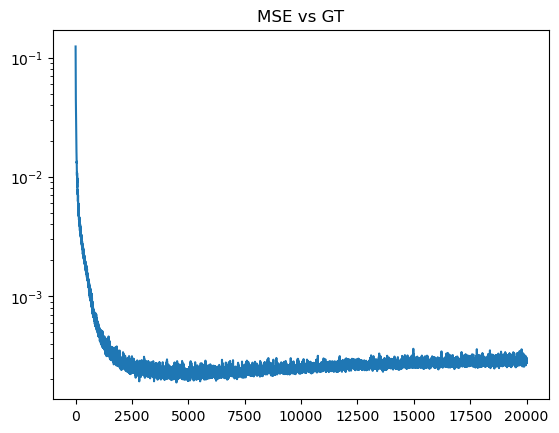

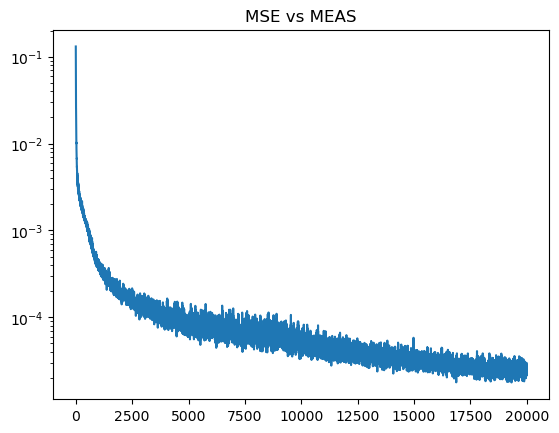

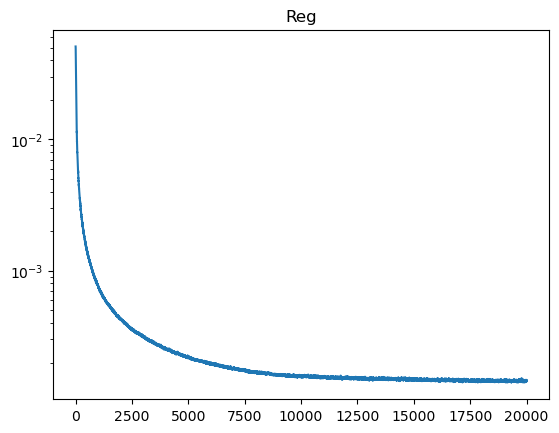

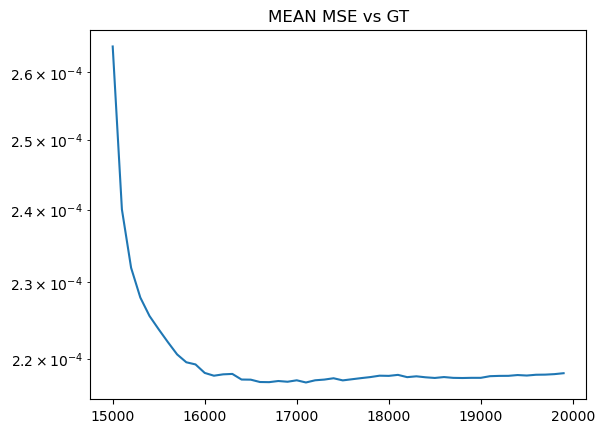

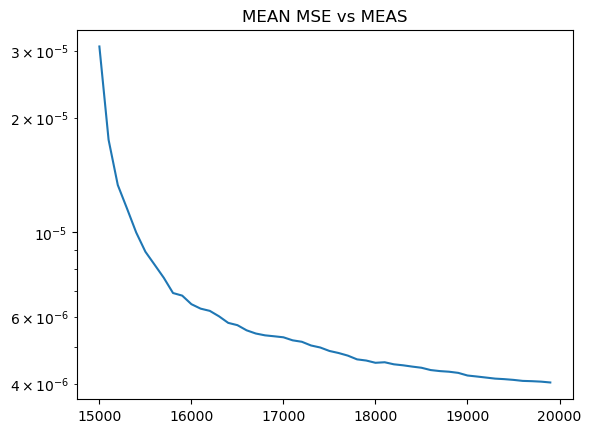

In [188]:
MAX_IDX = 100

plt.figure()
plt.plot(dip_results.mse_list_gt)
plt.title("MSE vs GT")
# plt.ylim(0, dip_results.mse_list_gt[MAX_IDX])
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(dip_results.mse_list_meas)
plt.title("MSE vs MEAS")
# plt.ylim(0, dip_results.mse_list_meas[MAX_IDX])
plt.yscale("log")
plt.show()

if hasattr(dip_results, "reg_list"):
    plt.figure()
    plt.plot(dip_results.reg_list)
    plt.title("Reg")
    # plt.ylim(0, dip_results.reg_list[MAX_IDX])
    plt.yscale("log")
    plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_gt)
plt.title("MEAN MSE vs GT")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_meas)
plt.title("MEAN MSE vs MEAS")
plt.yscale("log")
plt.show()

In [189]:
mean_out = torch.mean(torch.cat(dip_results.out_list), dim=0, keepdim=True)
std_out = torch.std(torch.cat(dip_results.out_list), dim=0, keepdim=True)

In [190]:
last_out = dip_results.out_list[-1]

In [191]:
mean_out_mag = utils.sparams_to_mag(mean_out)
std_out_mag = utils.sparams_to_mag(std_out)

In [192]:
last_out_mag = utils.sparams_to_mag(last_out)

In [193]:
x_mag = utils.sparams_to_mag(x_test)

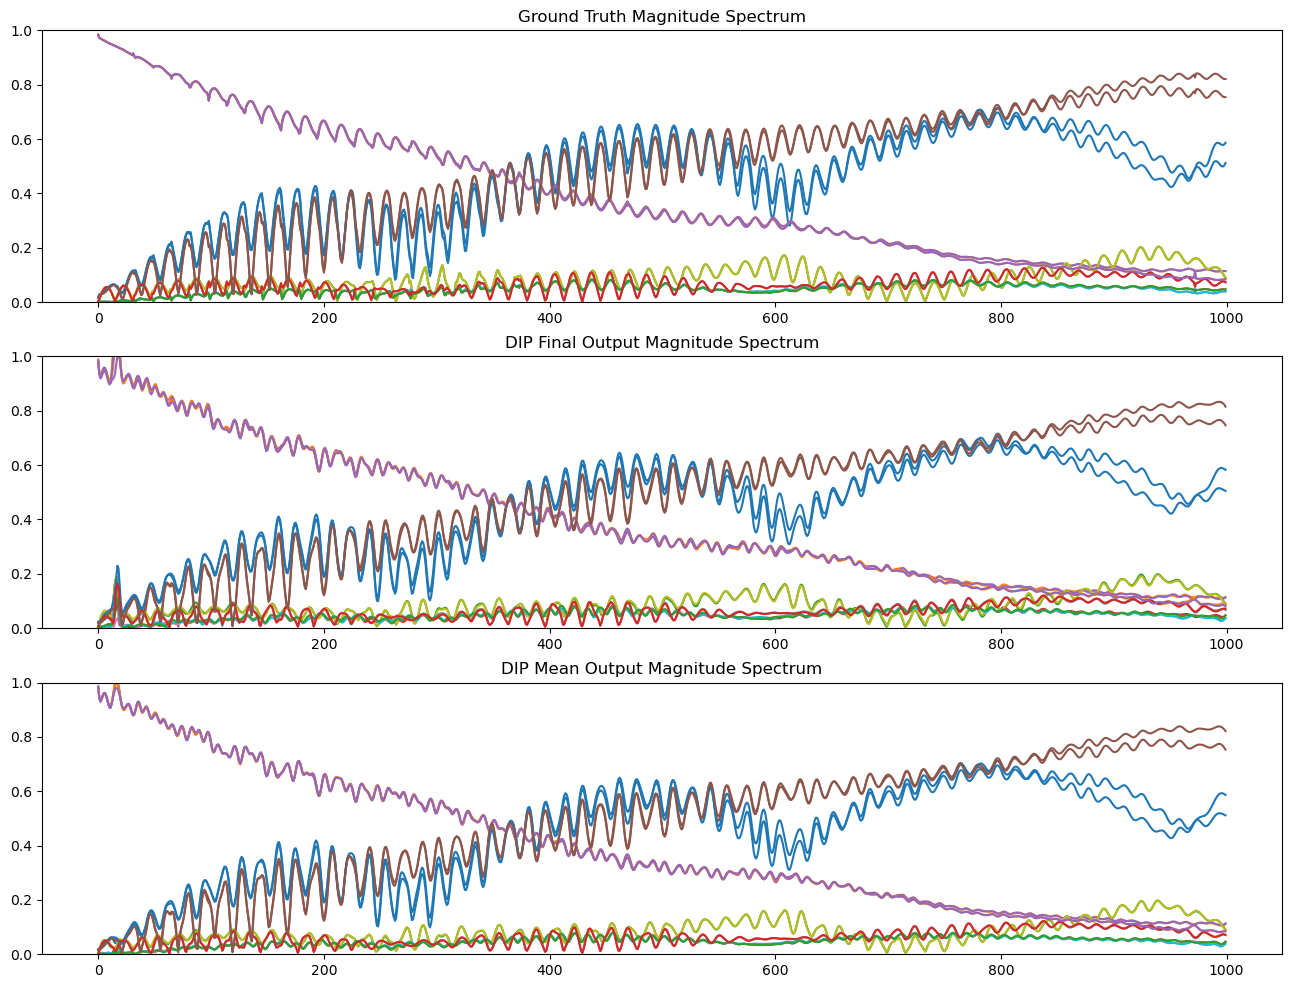

In [194]:
_, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(x_mag.shape[1]):
    axes[0].plot(x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[1].plot(last_out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Final Output Magnitude Spectrum")
axes[1].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[2].plot(mean_out_mag[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Mean Output Magnitude Spectrum")
axes[2].set_ylim(0,1)

plt.show()

Text(0.5, 1.0, 'Mean')

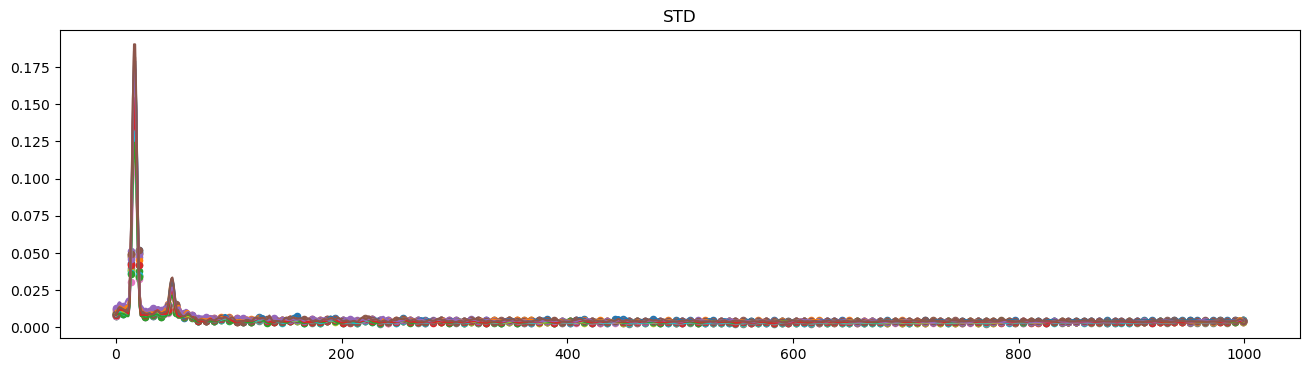

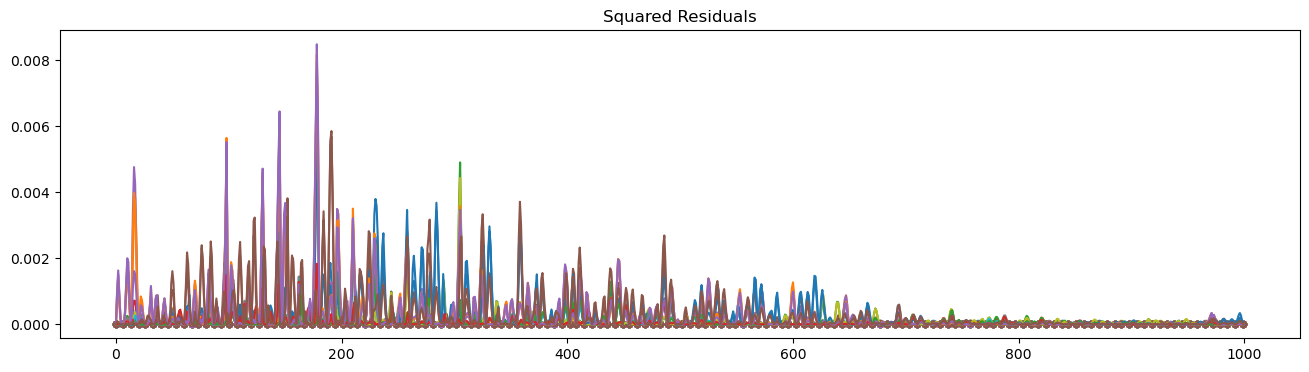

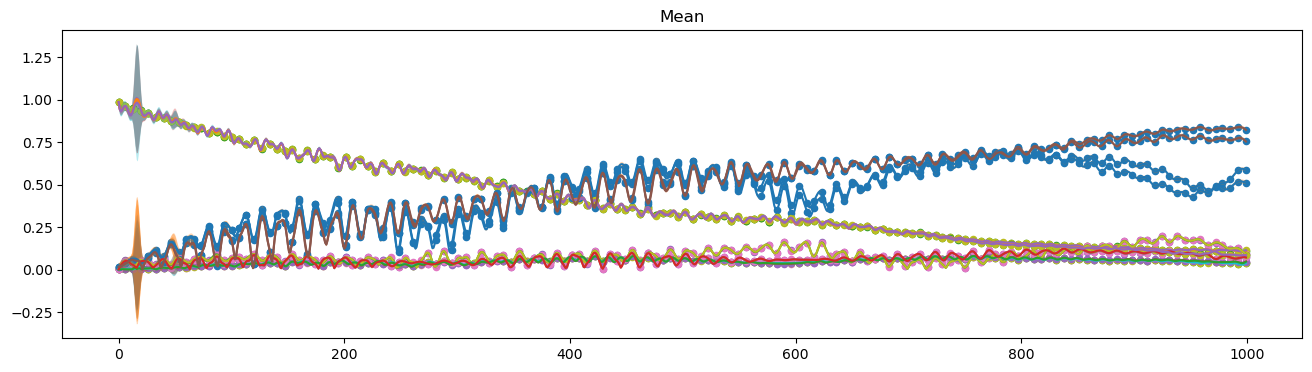

In [195]:
under_line = mean_out_mag - 1.96*std_out_mag
over_line = mean_out_mag + 1.96*std_out_mag

resid_mag = torch.square(x_mag - mean_out_mag)

plt.figure(figsize=(16,4))
for i in range(std_out_mag.shape[1]):
    plt.plot(std_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(KEPT_INDS, std_out_mag[0,i][KEPT_INDS].detach().cpu(), s=20)
plt.title("STD")

plt.figure(figsize=(16,4))
for i in range(resid_mag.shape[1]):
    plt.plot(resid_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(KEPT_INDS, resid_mag[0,i][KEPT_INDS].detach().cpu(), s=20)
plt.title("Squared Residuals")

plt.figure(figsize=(16,4))
for i in range(mean_out_mag.shape[1]):
    plt.plot(np.arange(N_FREQS), mean_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(KEPT_INDS, mean_out_mag[0,i][KEPT_INDS].detach().cpu(), s=20)
    plt.fill_between(np.arange(N_FREQS), under_line[0,i].detach().cpu(), over_line[0,i].detach().cpu(), alpha=0.3)
plt.title("Mean")

# Fit a VF

y_freqs = test_net.frequency[KEPT_INDS]

meas_matrix = torch.transpose(y.squeeze(), 0, 1).view(-1, N_PORTS, N_PORTS, 2)
print(meas_matrix.shape)

meas_network = utils.matrix_to_network(meas_matrix, y_freqs.f, "Observations for Chip "+str(CHIP_NUM))

from VF import vectorfit

fitter = vectorfit.VectorFitter(meas_network, number_of_failed_improvements_before_quit=2, verbose=False)

vf_output = fitter.vector_fit("Measurements", test_net.frequency.f)

vf_output.fitted_network = vectorfit.VectorFitter.fill_fitted_network(test_net.frequency.f, vf_output.vector_fit_model)

vf_out = utils.network_to_sparams(vf_output.fitted_network)

print("vf_out shape: ", vf_out.shape)

# Metrics and final comparison

In [196]:
print(mean_out.shape)
print(last_out.shape)

torch.Size([1, 32, 1000])
torch.Size([1, 32, 1000])


In [197]:
print(x_test.shape)

torch.Size([1, 32, 1000])


In [198]:
print(x_HLAS.shape)

torch.Size([1, 32, 1000])


In [199]:
psnr_mean = psnr(x_test.detach().cpu().numpy(), mean_out.detach().cpu().numpy())
psnr_last = psnr(x_test.detach().cpu().numpy(), last_out.detach().cpu().numpy())
# psnr_VF = psnr(x_test.detach().cpu().numpy(), vf_out.detach().cpu().numpy())
psnr_HLAS = psnr(x_test.detach().cpu().numpy(), x_HLAS.detach().cpu().numpy())

In [200]:
print("M / N: ", M / N_FREQS)

M / N:  0.15


In [201]:
print("MEAN PSNR: ", psnr_mean)
print("LAST PSNR: ", psnr_last)
# print("VF PSNR: ", psnr_VF)
print("HLAS PSNR: ", psnr_HLAS)

MEAN PSNR:  42.63353454498525
LAST PSNR:  41.41541224836072
HLAS PSNR:  37.34894233591237


In [202]:
x_HLAS_mag = utils.sparams_to_mag(x_HLAS)
# vf_out_mag = utils.sparams_to_mag(vf_out)

In [203]:
print(mean_out_mag.shape)
print(last_out_mag.shape)
print(x_HLAS_mag.shape)
# print(vf_out_mag.shape)
print(x_mag.shape)

torch.Size([1, 16, 1000])
torch.Size([1, 16, 1000])
torch.Size([1, 16, 1000])
torch.Size([1, 16, 1000])


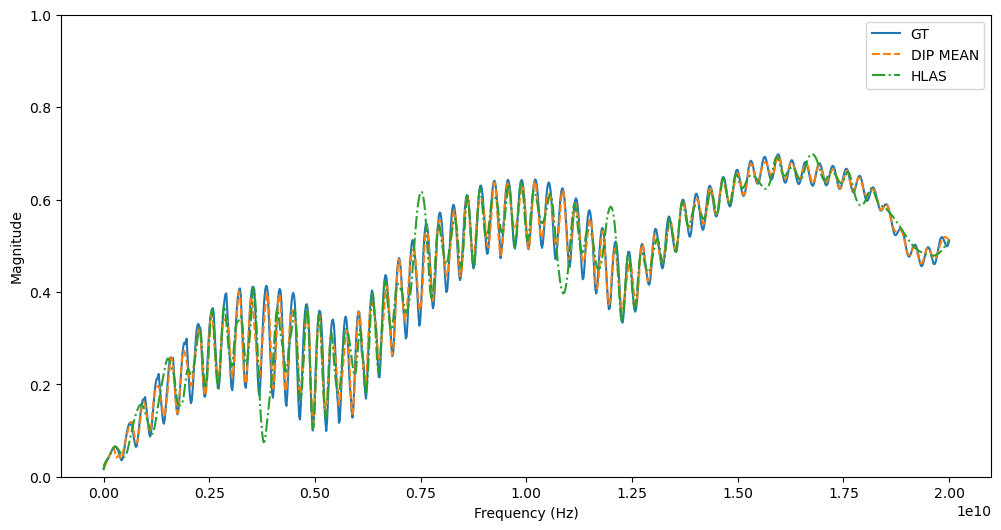

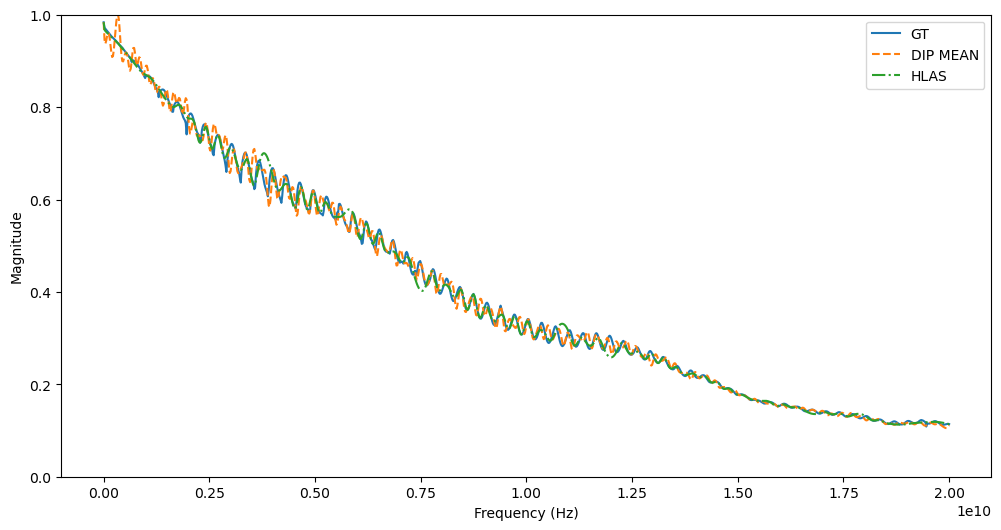

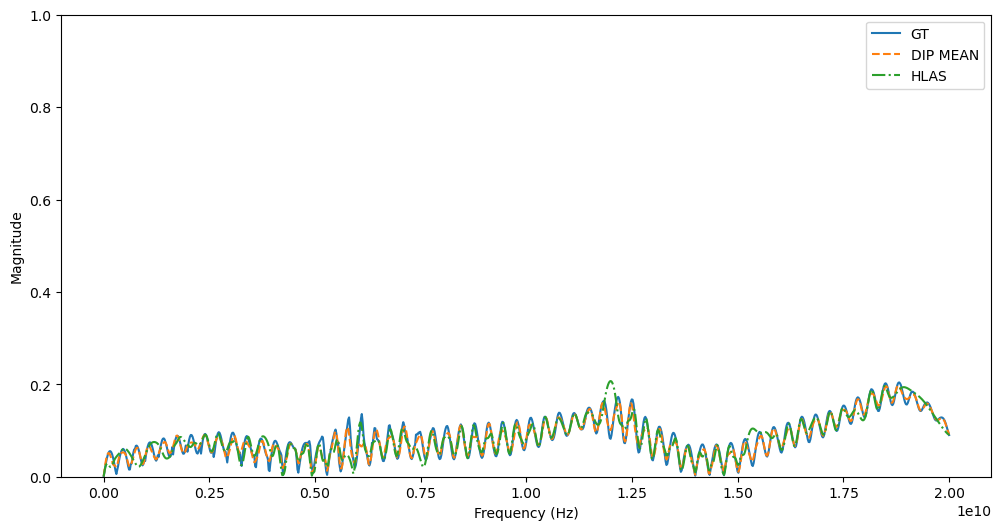

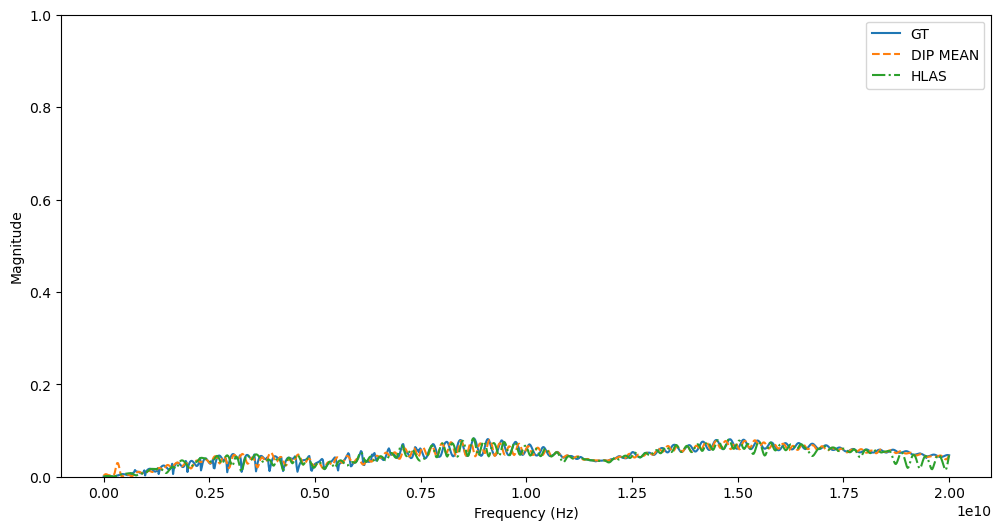

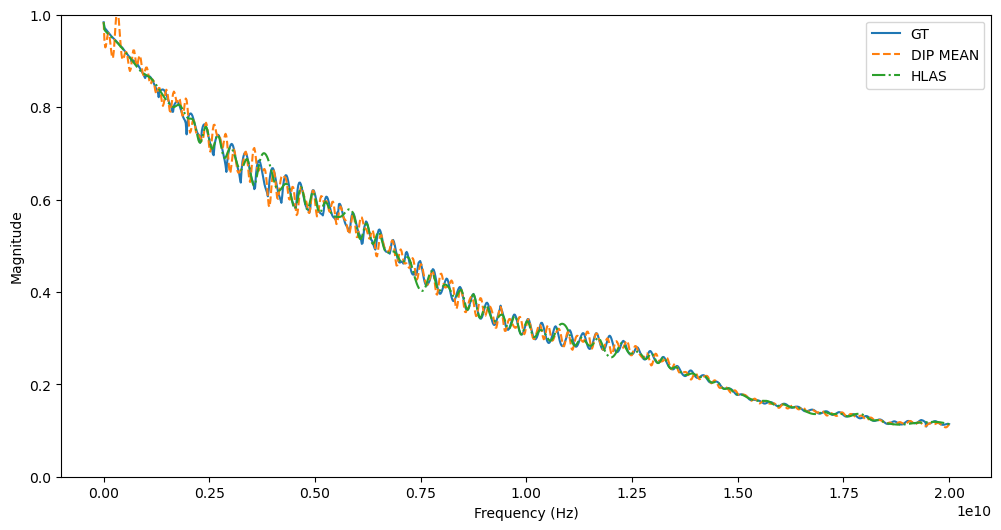

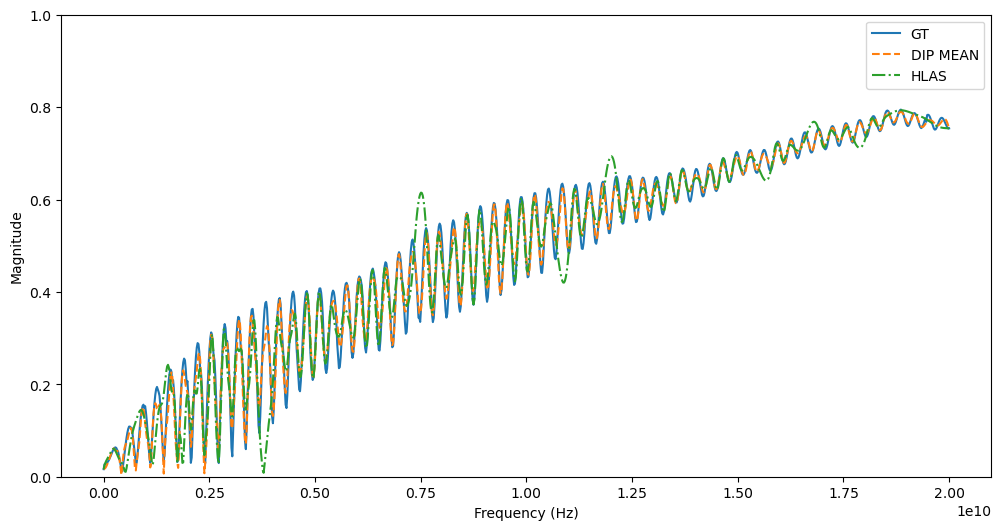

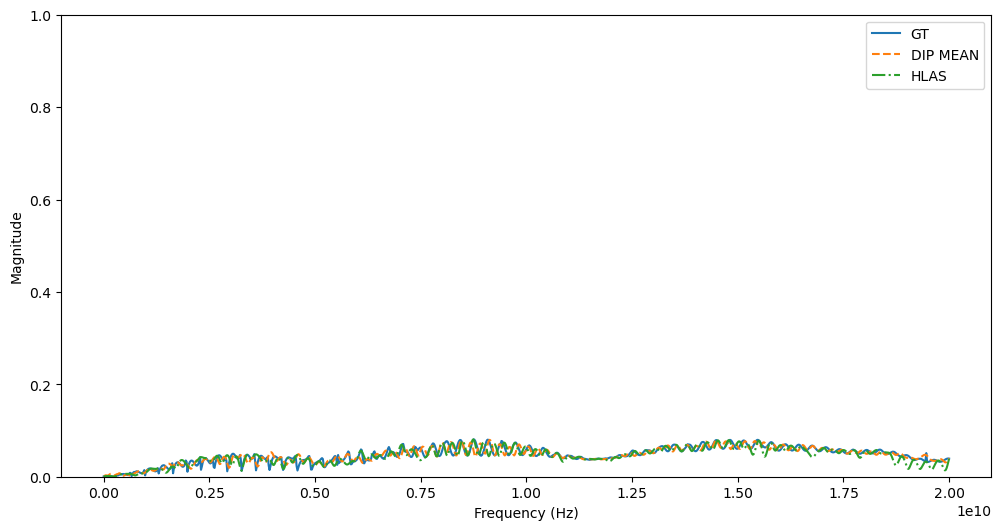

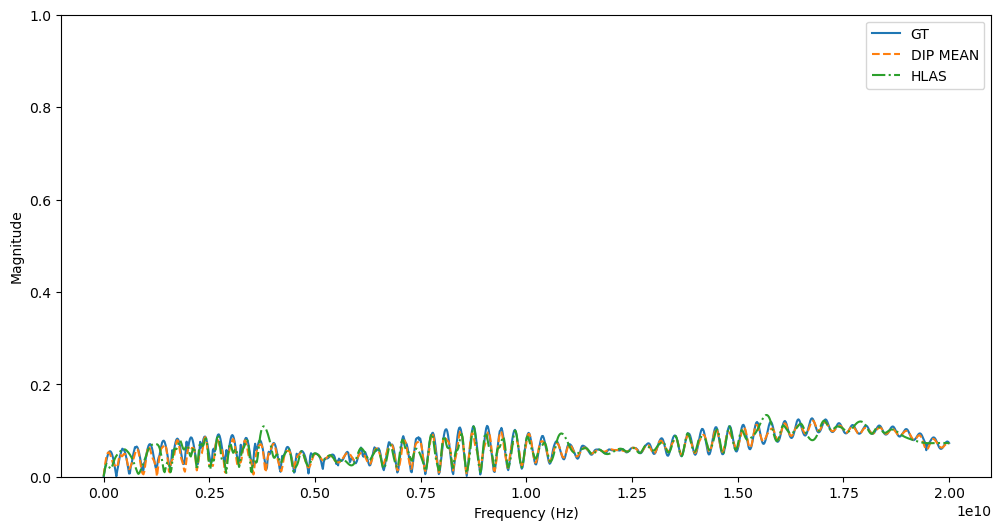

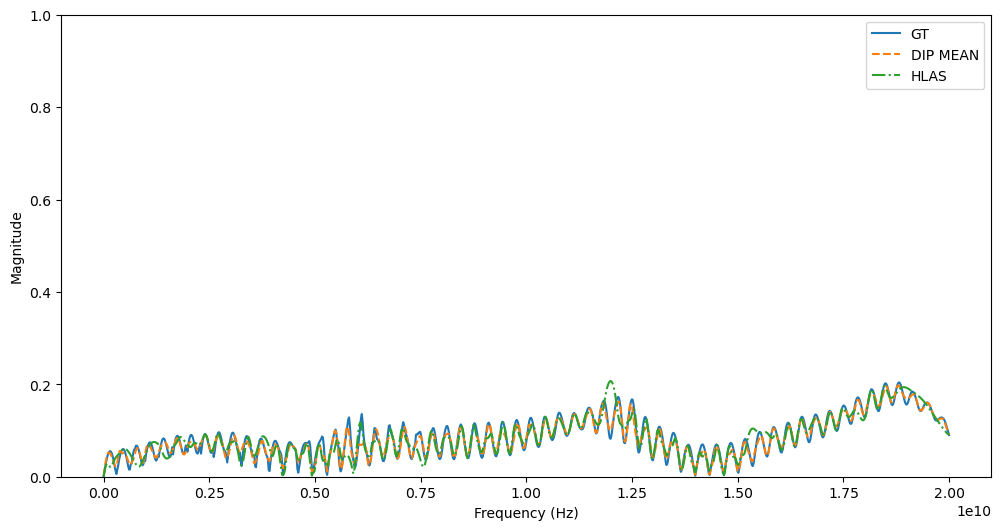

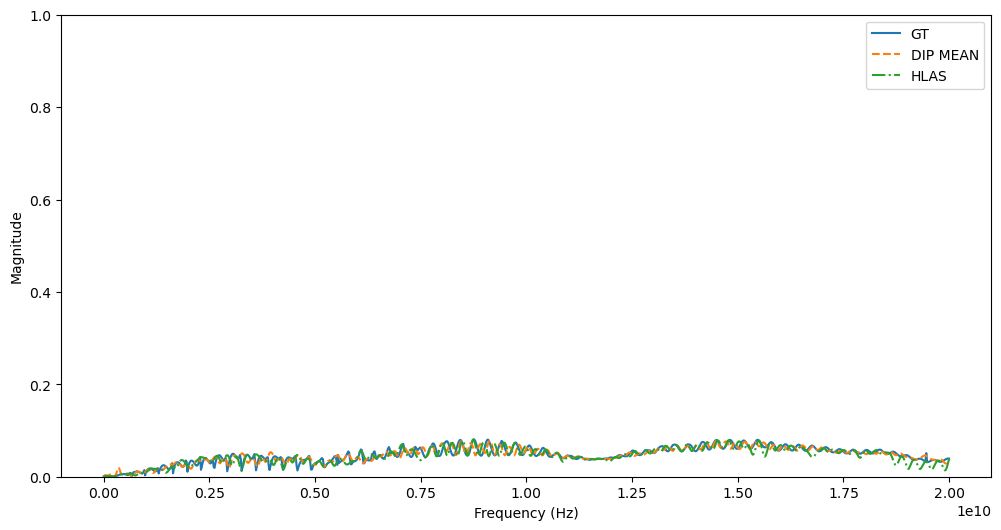

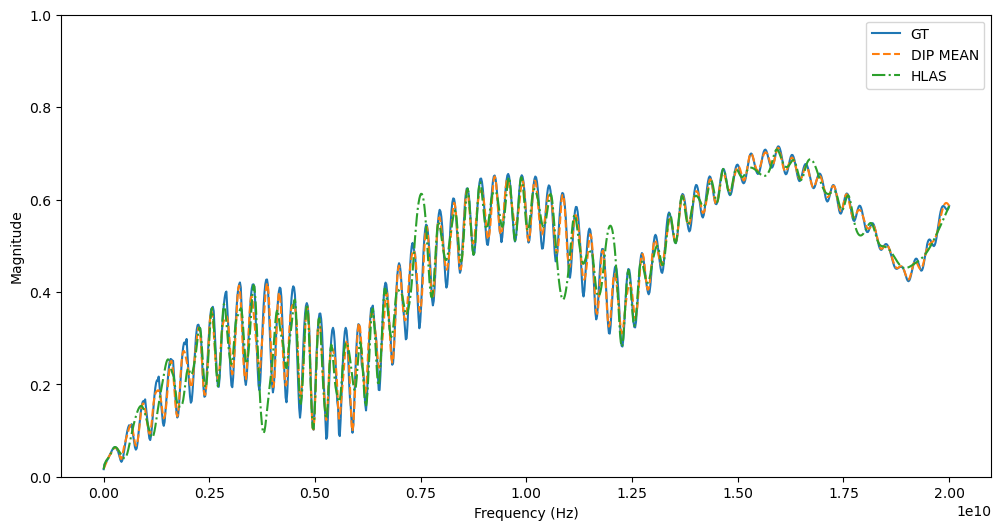

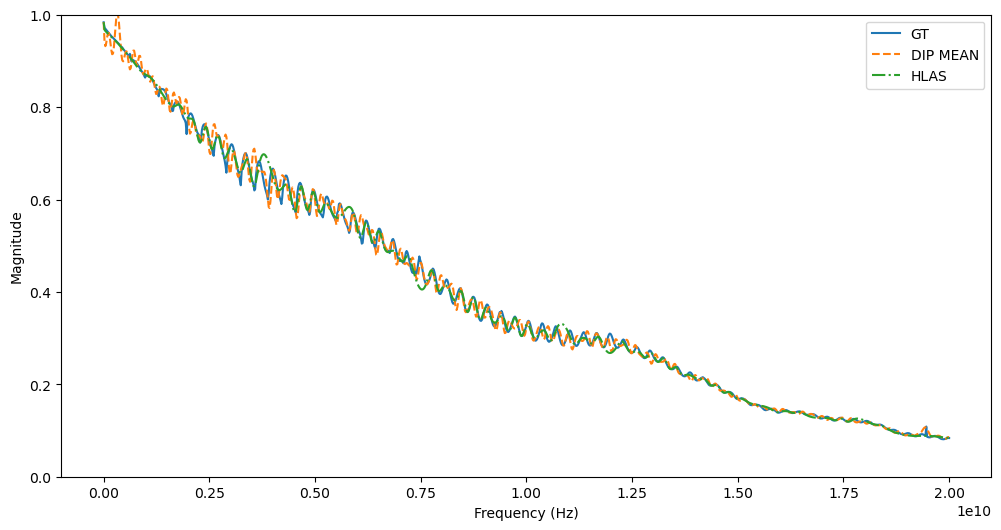

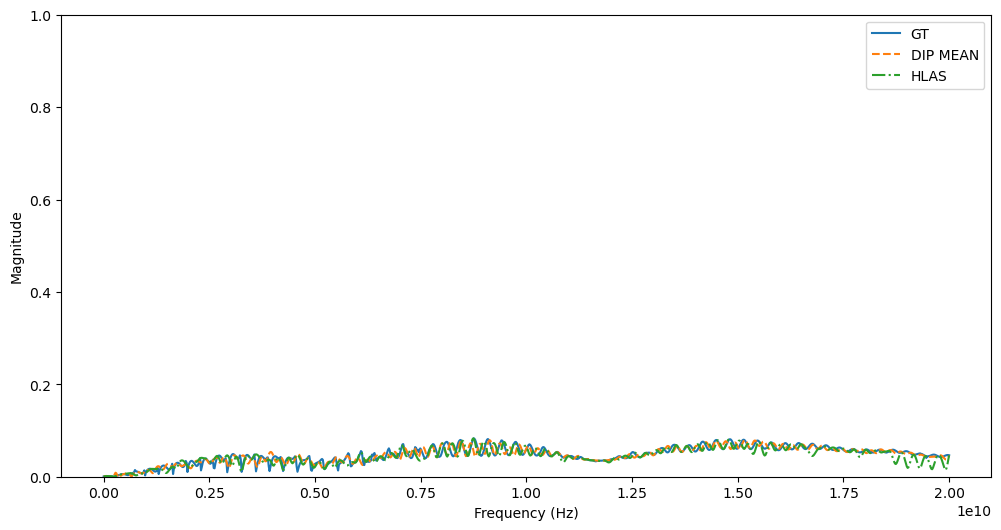

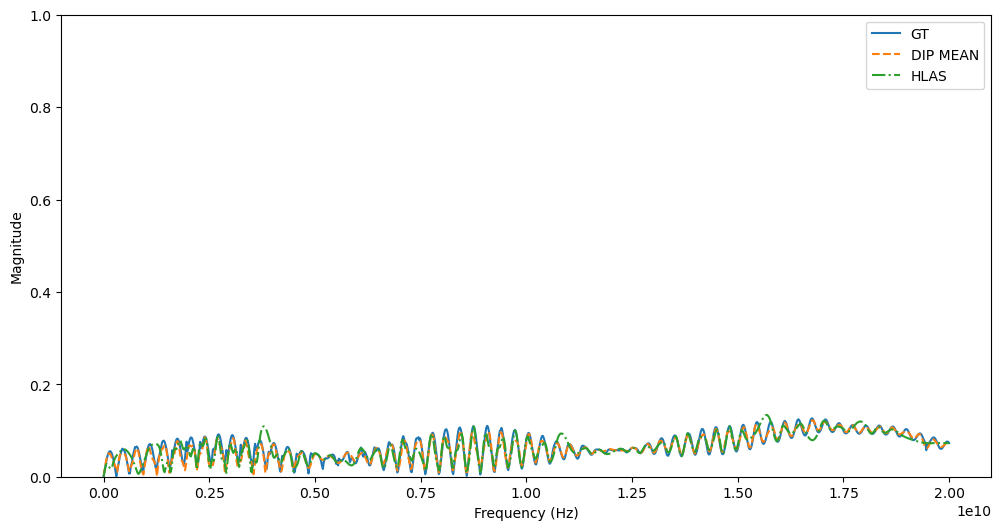

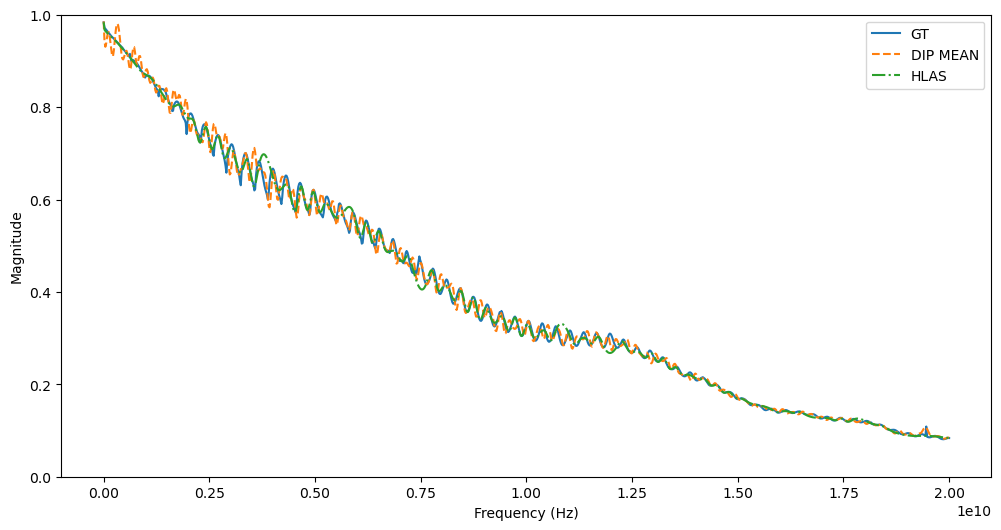

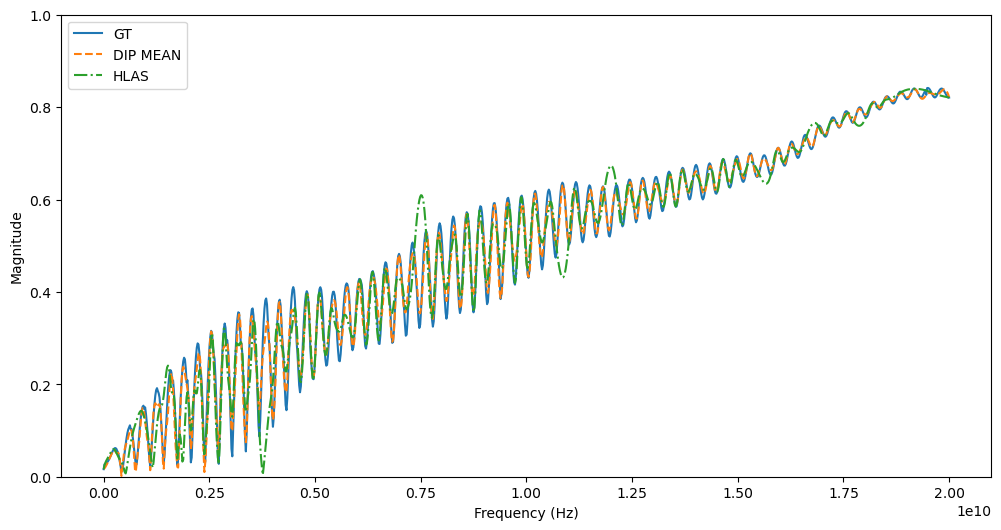

In [204]:
for i in range(x_mag.shape[1]):
    plt.figure(figsize=(12,6))
    plt.plot(test_net.frequency.f, x_mag[0,i].cpu(), label="GT")
    plt.plot(test_net.frequency.f, mean_out_mag[0,i].cpu(), label="DIP MEAN", linestyle="dashed")
    # plt.plot(test_net.frequency.f, last_out_mag[0,i].cpu(), label="DIP LAST", alpha=0.5, linestyle="dotted")
    plt.plot(test_net.frequency.f, x_HLAS_mag[0,i].cpu(), label="HLAS", linestyle="dashdot")
    # plt.plot(test_net.frequency.f, vf_out_mag[0,i].cpu(), label="VF", linestyle="dotted")
    plt.legend()
    plt.ylabel("Magnitude")
    plt.xlabel("Frequency (Hz)")
    plt.ylim(0, 1)
    plt.show()

for i in range(x_mag.shape[1]):
    plt.figure(figsize=(12,6))
    plt.plot(test_net.frequency.f, x_mag[0,i].cpu(), label="Reference", linewidth=2)
    plt.plot(test_net.frequency.f, mean_out_mag[0,i].cpu(), label="DIP", linestyle="dashed", linewidth=2)
    # plt.plot(test_net.frequency.f, last_out_mag[0,i].cpu(), label="DIP LAST", alpha=0.5, linestyle="dotted")
    plt.plot(test_net.frequency.f, x_HLAS_mag[0,i].cpu(), label="VF (proprietary)", linestyle="dashdot", linewidth=2)
    plt.plot(test_net.frequency.f, vf_out_mag[0,i].cpu(), label="VF (public)", linestyle="dotted", linewidth=2)
    if i==0:
        plt.legend(fontsize=18)
    plt.ylabel("Magnitude", fontsize=18)
    plt.xlabel("Frequency (GHz)", fontsize=18)
    plt.xticks(np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])*(1e10), ['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20'], fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig("/work/04703/sravula/ls6/CurveFitting-DIP/Figures/"+str(i)+".pdf", bbox_inches="tight")
    plt.show()